## Imports & Settings ( Colab 환경 가정)

In [0]:
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')
import sys
import os
sys.path.insert(0, '/content/gdrive/My Drive/Colab Notebooks/2019-1_ImageCaptioning_Proj')


from cache import cache
import coco


import tensorflow as tf
import numpy as np
import sys

from PIL import Image




print(sys.path)

import matplotlib.pyplot as plt

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding

from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
['/content/gdrive/My Drive/Colab Notebooks/2019-1_ImageCaptioning_Proj', '', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


##  Data Loading


http://cocodataset.org

In [0]:
coco.maybe_download_and_extract()


_, filenames_train, captions_train = coco.load_records(train=True)
_, filenames_val, captions_val = coco.load_records(train=False)

  

num_images_train = len(filenames_train)
num_images_train


- Download progress: 100.0%Done.
- Download progress: 100.0%
Download finished. Extracting files.
Done.
- Download progress: 99.9%Done.
- Data saved to cache-file: data/coco/records_train.pkl
- Data saved to cache-file: data/coco/records_val.pkl


118287

### Loading and Showing Image 함수 




This wire metal rack holds several pairs of shoes and sandals
A dog sleeping on a show rack in the shoes.
Various slides and other footwear rest in a metal basket outdoors.
A small dog is curled up on top of the shoes
a shoe rack with some shoes and a dog sleeping on them


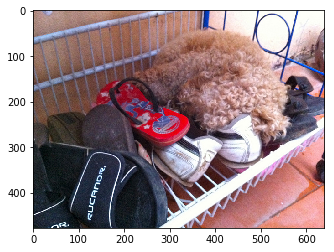

In [0]:
def load_image(path, size=None):

    img = Image.open(path)
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    img = np.array(img)

    img = img / 255.0

    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return img
  
   
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    path = os.path.join(dir, filename)

    for caption in captions:
        print(caption)
    img = load_image(path)
    plt.imshow(img)
    plt.show()
    
show_image(idx=5, train=True)



## Pre-Trained Image Model 비교



In [0]:

from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications import InceptionV3
from tensorflow.python.keras.applications.resnet50  import ResNet50


#image_model = VGG16(include_top=True, weights='imagenet')

image_model = InceptionV3(include_top=True, weights='imagenet')

#image_model = ResNet50(include_top=True, weights='imagenet')



image_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 3s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_

In [0]:
# vgg 16일 때
#transfer_layer = image_model.get_layer('fc2')

# Inception V3 & RESNET 50 일 때 
transfer_layer = image_model.get_layer('avg_pool')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

img_size = K.int_shape(image_model.input)[1:3]
print(img_size)

transfer_values_size = K.int_shape(transfer_layer.output)[1]
print(transfer_values_size)

(299, 299)
2048


The model expects input images to be of this size:

### Process All Images



In [0]:
def print_progress(count, max_count):

    pct_complete = count / max_count

    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    sys.stdout.write(msg)
    sys.stdout.flush()

processing the given files using Pretrained Model (Inception V3) and returning their transfer-values.

In [0]:
def process_images(data_dir, filenames, batch_size=32):

    num_images = len(filenames)

    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    start_index = 0

    while start_index < num_images:
        print_progress(count=start_index, max_count=num_images)

        end_index = start_index + batch_size

        if end_index > num_images:
            end_index = num_images

        current_batch_size = end_index - start_index

        for i, filename in enumerate(filenames[start_index:end_index]):
            path = os.path.join(data_dir, filename)

            img = load_image(path, size=img_size)

            image_batch[i] = img


        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        start_index = end_index

    print()

    return transfer_values
  
  
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")

    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values
  
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    # Path for the cache-file.
    
    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values
  
  

transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)



transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 118287 images in training-set ...
- Progress: 100.0%
- Data saved to cache-file: data/coco/transfer_values_train.pkl
dtype: float16
shape: (118287, 2048)
Processing 5000 images in validation-set ...
- Progress: 99.8%
- Data saved to cache-file: data/coco/transfer_values_val.pkl
dtype: float16
shape: (5000, 2048)


## Tokenizer


In [0]:

mark_start = 'start '
mark_end = ' end'


def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked
  
  
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]


print(captions_train[0])


def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list
  
  
captions_train_flat = flatten(captions_train_marked)

['Closeup of bins of food that include broccoli and bread.', 'A meal is presented in brightly colored plastic trays.', 'there are containers filled with different kinds of foods', 'Colorful dishes holding meat, vegetables, fruit, and bread.', 'A bunch of trays that have different food.']


In [0]:
num_words = 15000


class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):

        Tokenizer.__init__(self, num_words=num_words)

        self.fit_on_texts(texts)
        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        

        text = " ".join(words)
        return text
    
    def captions_to_tokens(self, captions_listlist):
       
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        return tokens
      
      

tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

token_start = tokenizer.word_index[mark_start.strip()]
token_end = tokenizer.word_index[mark_end.strip()]

## Data Generator


In [0]:

tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

def get_random_caption_tokens(idx):

    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        j = np.random.choice(len(tokens_train[i]))
        tokens = tokens_train[i][j]
        result.append(tokens)
    return result

This generator function creates random batches of training-data for use in training the neural network.

In [0]:
def batch_generator(batch_size):

    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train,
                                size=batch_size)

        transfer_values = transfer_values_train[idx]
        tokens = get_random_caption_tokens(idx)
        num_tokens = [len(t) for t in tokens]        
        max_tokens = np.max(num_tokens)
        

        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')

        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)
        
batch_size = 512

generator = batch_generator(batch_size=batch_size)

batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

### Steps Per Epoch


In [0]:
num_captions_train = [len(captions) for captions in captions_train]
total_num_captions_train = np.sum(num_captions_train)
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch


os.chdir('/content/gdrive/My Drive/Colab Notebooks/2019-1_ImageCaptioning_Proj/')

## Create the Recurrent Neural Network



In [0]:
state_size = 512
embedding_size = 128

transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

decoder_input = Input(shape=(None, ), name='decoder_input')

decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)
decoder_gru4 = GRU(state_size, name='decoder_gru4',
                   return_sequences=True)

decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

### Connect and Create the Training Model


In [0]:
from tensorflow.python.keras.layers import Dropout

def connect_decoder(transfer_values):

    initial_state = decoder_transfer_map(transfer_values)

    net = decoder_input    
    net = decoder_embedding(net)
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = Dropout(0.5)(net)
    net = decoder_gru3(net, initial_state=initial_state)
    net = Dropout(0.5)(net)
    net = decoder_gru4(net, initial_state=initial_state)
    
    decoder_output = decoder_dense(net)    
    return decoder_output

  
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Loss Function


In [0]:
# decoder_model.compile(optimizer=optimizer,
#                       loss='sparse_categorical_crossentropy')

def sparse_cross_entropy(y_true, y_pred):

    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

### Compile the Training Model


In [0]:
optimizer = RMSprop(lr=1e-3)

decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

### Callback Functions


In [0]:
path_checkpoint = 'IC_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)


callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)


callbacks = [callback_checkpoint, callback_tensorboard]

### Load Checkpoint


In [0]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = 'IC_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


### Train the Model


In [0]:

decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=25,
                            callbacks=callbacks)

Epoch 1/25
1154/1155 [============================>.] - ETA: 0s - loss: 1.4727
Epoch 00001: saving model to IC_checkpoint.keras
1155/1155 [==============================] - 617s 535ms/step - loss: 1.4725
Epoch 2/25
1154/1155 [============================>.] - ETA: 0s - loss: 1.0735
Epoch 00002: saving model to IC_checkpoint.keras
1155/1155 [==============================] - 612s 530ms/step - loss: 1.0737
Epoch 3/25
1154/1155 [============================>.] - ETA: 0s - loss: 1.0375
Epoch 00003: saving model to IC_checkpoint.keras
1155/1155 [==============================] - 607s 526ms/step - loss: 1.0374
Epoch 4/25
1154/1155 [============================>.] - ETA: 0s - loss: 1.0219
Epoch 00004: saving model to IC_checkpoint.keras
1155/1155 [==============================] - 604s 523ms/step - loss: 1.0217
Epoch 5/25
1154/1155 [============================>.] - ETA: 0s - loss: 0.9830
Epoch 00005: saving model to IC_checkpoint.keras
1155/1155 [==============================] - 618s 535ms/

## Generate Captions

This function loads an image and generates a caption using the model we have trained.

In [0]:
def generate_caption(image_path, max_tokens=30):

    image = load_image(image_path, size=img_size)

    image_batch = np.expand_dims(image, axis=0)

    transfer_values = image_model_transfer.predict(image_batch)

    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    token_int = token_start
    output_text = ''
    count_tokens = 0
    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }


        decoder_output = decoder_model.predict(x_data)
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)
        sampled_word = tokenizer.token_to_word(token_int)
        output_text += " " + sampled_word
        count_tokens += 1
    output_tokens = decoder_input_data[0]

    plt.imshow(image)
    plt.show()
    
    print("Predicted caption:")
    print(output_text)
    print()

/content/gdrive/My Drive/Colab Notebooks/2019-1_ImageCaptioning_Proj
['/content/gdrive/My Drive/Colab Notebooks/2019-1_ImageCaptioning_Proj', '', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


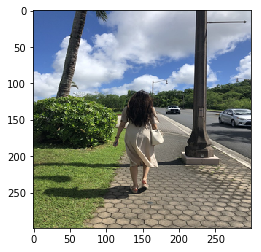

Predicted caption:
 a woman is standing on the sidewalk with a frisbee end



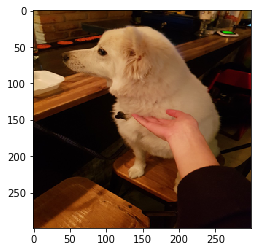

Predicted caption:
 a dog sitting on a table next to a remote end



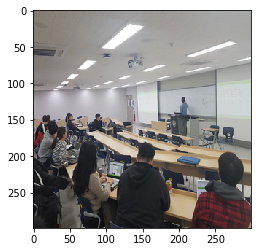

Predicted caption:
 a group of people are sitting at a table with food end



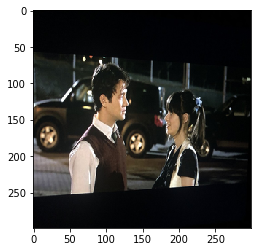

Predicted caption:
 a man and a woman are looking at a screen end



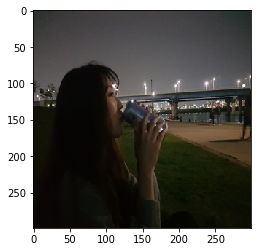

Predicted caption:
 a man taking a picture of himself in a stadium end



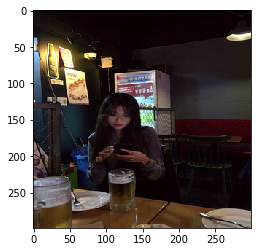

Predicted caption:
 a woman sitting at a table with a drink in front of her end



In [0]:

print(os.getcwd())
print(sys.path)
generate_caption("images/pic1.jpg")
generate_caption("images/pic3.jpg")
generate_caption("images/pic4.jpg")
generate_caption("images/pic5.jpg")
generate_caption("images/pic7.jpg")
generate_caption("images/pic8.jpg")


Helper-function for loading an image from the COCO data-set and printing the true captions as well as the predicted caption.

In [0]:
def generate_caption_coco(idx, train=False):

    if train:
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    path = os.path.join(data_dir, filename)

    generate_caption(image_path=path)


    print("True captions:")
    for caption in captions:
        print(caption)

train 시켰던 COCO 이미지 Captioning 해보기


In [0]:
generate_caption_coco(idx=3, train=True)

generate_caption_coco(idx=12, train=True)

OSError: ignored

train 시키지 않은  COCO 이미지 Captioning 해보기


In [0]:
generate_caption_coco(idx=1, train=False)